## 05. GBM(Gradient Boosting Machine)

- 과적합에도 뛰어난 성능
- 시간 오래 걸림


In [1]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
from sklearn.metrics import accuracy_score
import pandas as pd
warnings.filterwarnings("ignore")

def get_new_feature_name(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby("column_name").cumcount(), columns=["dup_cnt"])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how="outer")
    new_feature_name_df["column_name"] = new_feature_name_df[["column_name", "dup_cnt"]].apply(lambda x: x[0] + "_" + str(x[1]) if x[1] > 0 else x[0], axis = 1)
    new_feature_name_df = new_feature_name_df.drop(["index"], axis = 1)
    return new_feature_name_df
    
def get_human_dataset():
    feature_name_df = pd.read_csv("./data/features.txt", sep="\s+", header=None, names=["column_index", "column_name"])
    new_feature_name_df = get_new_feature_name(feature_name_df)
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    X_train = pd.read_csv("./data/train/X_train.txt", sep="\s+", names = feature_name)
    X_test = pd.read_csv("./data/test/X_test.txt", sep="\s+", names = feature_name)
    y_train = pd.read_csv("./data/train/y_train.txt", sep="s+", header= None, names= ["action"])
    y_test = pd.read_csv("./data/test/y_test.txt", sep="s+", header= None, names= ["action"])
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state = 0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print(f"gb_accuracy: {gb_accuracy}")
print(f"dtime: {time.time() - start_time} sec")


gb_accuracy: 0.9392602646759416
dtime: 614.1745479106903 sec


### GBM 역시 GridSearchCV 로 하이퍼 파라미터 최적화를 할 수 있다. 너무 오래걸려서 못하겠음



## 06. XGBoost(eXtra Gradient Boost)

- GBM 느린 수행 시간, 과적합 규제 부재 해결
- 병렬 학습 가능


### 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측


In [2]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np 
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target
cancer_df = pd.DataFrame(data = X_features, columns = dataset.feature_names) 
cancer_df["target"] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [3]:
print(dataset.target_names)
print(cancer_df["target"].value_counts())


['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)

dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

params = {
    "max_depth": 3,
    "eta": 0.1,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
}
num_rounds = 400

wlist = [(dtrain, "train"), (dtest, "eval")] # watch list
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds, early_stopping_rounds = 100, evals = wlist, verbose_eval = 15)
# verbose_eval for showing less output


[0]	train-logloss:0.60969	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[15]	train-logloss:0.15362	eval-logloss:0.19999
[30]	train-logloss:0.06241	eval-logloss:0.11450
[45]	train-logloss:0.03365	eval-logloss:0.09418
[60]	train-logloss:0.02132	eval-logloss:0.09194
[75]	train-logloss:0.01539	eval-logloss:0.08860
[90]	train-logloss:0.01235	eval-logloss:0.08716
[105]	train-logloss:0.01039	eval-logloss:0.08677
[120]	train-logloss:0.00912	eval-logloss:0.08763
[135]	train-logloss:0.00822	eval-logloss:0.08882
[150]	train-logloss:0.00758	eval-logloss:0.08911
[165]	train-logloss:0.00718	eval-logloss:0.08752
[180]	train-logloss:0.00690	eval-logloss:0.08704
[195]	train-logloss:0.00665	eval-logloss:0.08598
[210]	train-logloss:0.00643	eval-logloss:0.08581
[225]	train-logloss:0.00623	eval-logloss:0.08587
[240]	train-logloss:0.00606	eval-logloss:0.08618
[255]	train-logloss:0.005

In [5]:
pred_probs = xgb_model.predict(dtest)
print("pred_probs[:10]")
print(np.round(pred_probs[:10], 3))

preds = [1 if x > 0.5 else 0 for x in pred_probs]
print("pred[:10]")
print(preds[:10])


pred_probs[:10]
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
pred[:10]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred = None, pred_proba = None):
    print("confusion_matrix")
    print(confusion_matrix(y_test, pred), "\n")
    print("auccracy: {0:.3f}, precision: {1:.3f}, recall: {2:.3f}, f1: {3:.3f}, roc_auc: {4:.3f}".format(accuracy_score(y_test,pred), precision_score(y_test, pred), recall_score(y_test, pred), f1_score(y_test, pred), roc_auc_score(y_test,pred_proba)))

get_clf_eval(y_test, preds, pred_probs)

confusion_matrix
[[35  2]
 [ 1 76]] 

auccracy: 0.974, precision: 0.974, recall: 0.987, f1: 0.981, roc_auc: 0.995


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

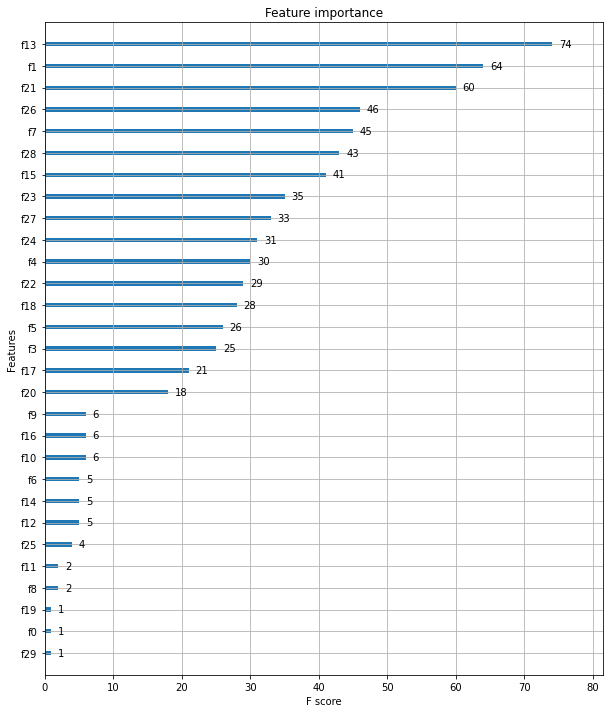

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(xgb_model, ax = ax) # f13 -> 14번째 피쳐

### 사이킷런 래퍼 XGBoost의 개요 및 적용

- 사이킷런 프레임워크와 연동, fit, predict 으로 학습, 예측
- GridSearchCV 같은 유틸리티 사용 가능.
- 파라미터명 살짝 바꿈


In [8]:
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, w_preds, w_pred_proba)

confusion_matrix
[[35  2]
 [ 1 76]] 

auccracy: 0.974, precision: 0.974, recall: 0.987, f1: 0.981, roc_auc: 0.995


In [9]:
evals = [(X_test, y_test)] # 평가 데이터로 테스트 데이터 하면 과적합 할수 있으니 학습시 완전히 알려지지 않는 데이터를 사용하는 게 좋음 (이 코드는 테스트를 평가데이터로 쓰고 있음)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, verbose = 15)


[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[15]	validation_0-logloss:0.19999
[30]	validation_0-logloss:0.11450
[45]	validation_0-logloss:0.09418
[60]	validation_0-logloss:0.09194
[75]	validation_0-logloss:0.08860
[90]	validation_0-logloss:0.08716
[105]	validation_0-logloss:0.08677
[120]	validation_0-logloss:0.08763
[135]	validation_0-logloss:0.08882
[150]	validation_0-logloss:0.08911
[165]	validation_0-logloss:0.08752
[180]	validation_0-logloss:0.08704
[195]	validation_0-logloss:0.08598
[210]	validation_0-logloss:0.08581
[225]	validation_0-logloss:0.08587
[240]	validation_0-logloss:0.08618
[255]	validation_0-logloss:0.08644
[270]	validation_0-logloss:0.08669
[285]	validation_0-logloss:0.08643
[300]	validation_0-logloss:0.08618
Stopping. Best iteration:
[211]	validation_0-logloss:0.08559



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

confusion_matrix
[[34  3]
 [ 1 76]] 

auccracy: 0.965, precision: 0.962, recall: 0.987, f1: 0.974, roc_auc: 0.995


In [11]:
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric = "logloss", eval_set = evals, verbose = 15)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)
# early stop = 10

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[15]	validation_0-logloss:0.19999
[30]	validation_0-logloss:0.11450
[45]	validation_0-logloss:0.09418
[60]	validation_0-logloss:0.09194
Stopping. Best iteration:
[52]	validation_0-logloss:0.08958

confusion_matrix
[[34  3]
 [ 2 75]] 

auccracy: 0.956, precision: 0.962, recall: 0.974, f1: 0.968, roc_auc: 0.995


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

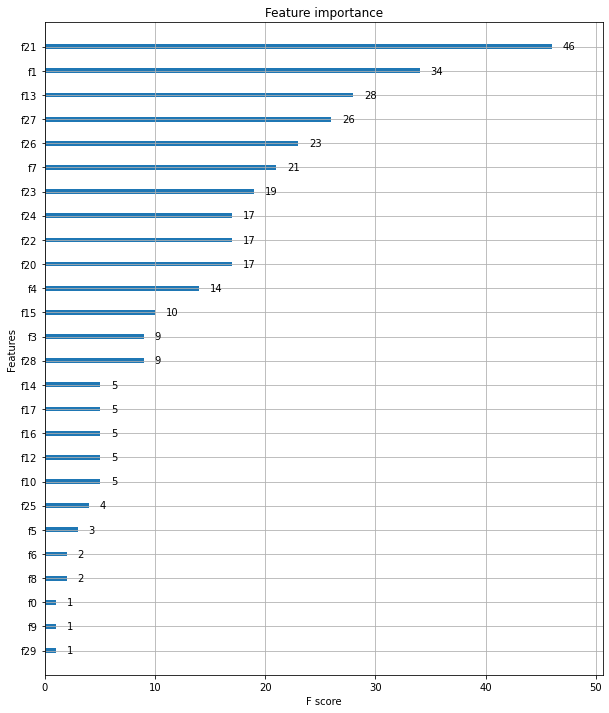

In [12]:
fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(xgb_wrapper, ax = ax) # 파이썬 xgboost 나 사이킷런 xgboost wrapper 둘다 plot_importance() 로 시각화 가능.


## 07. LightGBM

- xgboost 도 시간 오래 걸림 (gridsearchcv 하면)
- 이건 메모리 사용 적음, 학습 시간 더 적음, 카테고리형 피처 자동/최적 변환
- 예측 성능은 별로 차이 없음, 
- 적은 데이터 세트에 적용하면 과적합 발생하기 쉬운 단점 (만건 이하의 데이터)
- 균형 트리(Level Wise)
    - 균형 트리 만들어서 트리 깊이, 과적합 가능성 줄임
- 리프 중심 트리 분할 (Leaf Wise)
    - 깊이는 깊어지지만 예측 오류 손실을 최소화


### LightGBM 적용 - 위스콘신 유방암 예측



In [13]:
from lightgbm import LGBMClassifier

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size = 0.2, random_state = 156)
lgbm_wrapper = LGBMClassifier(n_estimators = 400)
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, verbose = 15)

Training until validation scores don't improve for 100 rounds
[15]	valid_0's binary_logloss: 0.203058
[30]	valid_0's binary_logloss: 0.136109
[45]	valid_0's binary_logloss: 0.122818
[60]	valid_0's binary_logloss: 0.134804
[75]	valid_0's binary_logloss: 0.14545
[90]	valid_0's binary_logloss: 0.156765
[105]	valid_0's binary_logloss: 0.167697
[120]	valid_0's binary_logloss: 0.178254
[135]	valid_0's binary_logloss: 0.189279
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.122818


LGBMClassifier(n_estimators=400)

In [14]:
pred = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

confusion_matrix
[[33  4]
 [ 1 76]] 

auccracy: 0.956, precision: 0.950, recall: 0.987, f1: 0.968, roc_auc: 0.991


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

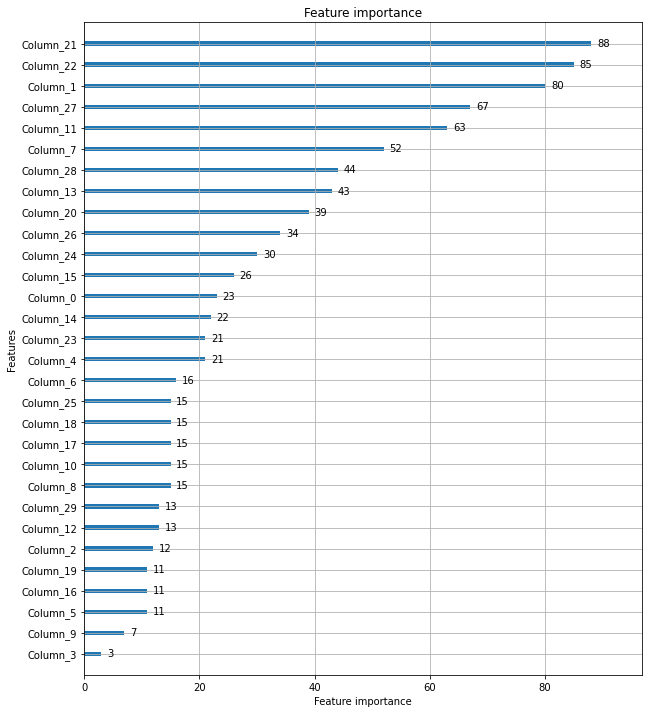

In [15]:
from lightgbm import plot_importance #lightgbm 도 plot_importance 있음

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(lgbm_wrapper, ax = ax) # wrapper 넣어도 됨.
